In this recipe, we're going to build taxonomic classifiers for amplicon sequencing. We'll do this for 16S using some scikit-learn classifiers.

In [2]:
%pylab inline
from __future__ import division
import numpy as np
import pandas as pd
import skbio
import qiime_default_reference

Populating the interactive namespace from numpy and matplotlib


We're going to work with the [``qiime-default-reference``](https://github.com/biocore/qiime-default-reference) so we have easy access to some sequences. For reasons we'll look at below, we're going to load the unaligned reference sequences (which are 97% OTUs) and the aligned reference sequences (which are 85% OTUs). If you want to adapt this recipe to train and test a classifier on other files, just set the variable names below to the file paths that you'd like to use for training. 

In [3]:
###
## UPDATE THIS CELL TO USE THE DEFAULT REFERENCE AGAIN!!
###

unaligned_ref_fp = qiime_default_reference.get_reference_sequences()
aligned_ref_fp = "/Users/caporaso/data/gg_13_8_otus/rep_set_aligned/97_otus.fasta" #qiime_default_reference.get_template_alignment()
tax_ref_fp = "/Users/caporaso/data/gg_13_8_otus/taxonomy/97_otu_taxonomy.txt" #qiime_default_reference.get_reference_taxonomy()

Several recent studies of amplicon taxonomic assignment methods  ([Mizrahi-Man et al. 2013](http://www.plosone.org/article/info%3Adoi%2F10.1371%2Fjournal.pone.0053608), [Werner et al. 2012](http://www.nature.com/ismej/journal/v6/n1/full/ismej201182a.html)) have suggested that training Naive Bayes taxonomic classifiers against only the region of a sequence that was amplified, rather than a full length sequence, will give better taxonomic assignment results. So, lets start by slicing our reference sequences by finding some commonly used 16S primers so we train only on the fragment of the 16S that we would amplify in an amplicon survey. 

We'll define the forward and reverse primers as ``skbio.DNA`` objects. The primers that we're using here are pulled from [Supplementary File 1](http://www.nature.com/ismej/journal/v6/n8/extref/ismej20128x2.txt) of [Caporaso et al. 2012](http://www.nature.com/ismej/journal/v6/n8/full/ismej20128a.html). Note that we're reverse complementing the reverse primer when we load it here so that it's in the same orientation as our reference sequences.

In [4]:
fwd_primer = skbio.DNA("GTGCCAGCMGCCGCGGTAA", {'id':'fwd-primer'})
rev_primer = skbio.DNA("GGACTACHVGGGTWTCTAAT", {'id':'rev-primer'}).reverse_complement()

The typical way to approach the problem of finding the boundaries of a short sequence in a longer sequence would be to use pairwise alignment. But, we're going to try a different approach here since pairwise alignment is inherently slow (it scales quadratically). Because these are sequencing primers, they're designed to be unique (so there shouldn't be multiple matches of a primer to a sequence), and they're designed to match as many sequences as possible. So let's try using regular expressions to match our sequencing primers in the reference database. Regular expression matching scales lineaerly, so is *much* faster to apply to many sequences.

First, we'll define a function to generate a regular expression from a ``Sequence`` object. This functionality will be in scikit-bio's next official release (it was recently added as part of [issue #1005](https://github.com/biocore/scikit-bio/issues/1005)). 

In [5]:
def seq_to_regex(seq):
    """ Convert a sequence to a regular expression
    """
    result = []
    sequence_class = seq.__class__
    for base in str(seq):
        if base in sequence_class.degenerate_chars:
            result.append('[{0}]'.format(
                ''.join(sequence_class.degenerate_map[base])))
        else:
            result.append(base)

    return ''.join(result)

We can then apply this to define a regular expression that will match our forward primer, the following sequence, and then the reverse primer. We can use the resulting matches then to find the region of our sequences that is bound by our forward and reverse primer.

In [6]:
regex = '({0}.*{1})'.format(seq_to_regex(fwd_primer),
                            seq_to_regex(rev_primer))

In [7]:
regex

'(GTGCCAGC[AC]GCCGCGGTAA.*ATTAGA[AT]ACCC[CTG][ATG]GTAGTCC)'

Next, let's apply this to all of our unaligned sequence and find out how many reference sequences our pattern matches.

In [8]:
seq_count = 0
match_count = 0
for seq in skbio.io.read(unaligned_ref_fp, format='fasta', 
                         constructor=skbio.DNA):
    seq_count += 1
    for match in seq.find_with_regex(regex):
        match_count += 1

match_percentage = (match_count / seq_count) * 100
print('{0} of {1} ({2:.2f}%) sequences have exact matches to the regular expression.'.format(match_count, seq_count, match_percentage))

KeyboardInterrupt: 

So we're matching only about 80% of our reference sequences with this pattern. The implication for this application is that we'd only know how to slice 80% of our sequences, and as a result, we'd only have 80% of our sequence to train on. In addition to this being a problem because we want to train on as many sequences possible, it's very likely that there are certain taxonomic groups are left out all together. So, using regular expressions this way won't work.

However... this is exactly what multiple sequence alignments are good for. If we could match our primers against aligned reference sequences, then finding matches in 80% of our sequences would give us an idea of how to slice all of our sequences, since the purpose of a multiple sequence alignment is to normalize the position numbers across all of the sequences in a sequence collection. The problem is that the gaps in the alignment would make it harder to match our regular expression, as gaps would show up that disrupt our matches. We can get around this using the ``ignore`` parameter to ``DNA.find_with_regex``, which takes a boolean vector (a fancy name for an array or list of boolean values) indicating positions that should be ignore in the regular expression match. Let's try applying our regular expression to the aligned reference sequences and keeping track of where each match starts and stops. 

In [ ]:
starts = []
stops = []
for seq in skbio.io.read(aligned_ref_fp, format='fasta', 
                         constructor=skbio.DNA):
    for match in seq.find_with_regex(regex, ignore=seq.gaps()):
        starts.append(match.start)
        stops.append(match.stop)

If we now look at the distribution of the start and stop positions of each regular expression match, we see that each distribution is narrowly focused around certain positions. We can use those to define the region that we want to slice from our reference alignment, and then remove the gaps from all sequences to train our classifiers.

In [ ]:
pd.Series(starts).describe()

In [10]:
pd.Series(stops).describe()

count    81851.000000
mean      4090.005131
std          1.332906
min       4090.000000
25%       4090.000000
50%       4090.000000
75%       4090.000000
max       4471.000000
dtype: float64

In [11]:
locus = slice(int(np.median(starts)), int(np.median(stops)))
locus

slice(2227, 4090, None)

In [12]:
subset_fraction = 1.0
kmer_counts = []
seq_ids = []

for seq in skbio.io.read(aligned_ref_fp, format='fasta',
                         constructor=skbio.DNA):
    if np.random.random() > subset_fraction: continue
    seq_ids.append(seq.metadata['id'])
    sliced_seq = seq[locus].degap()
    kmer_counts.append(sliced_seq.kmer_frequencies(8))

In [13]:
from sklearn.feature_extraction import DictVectorizer
X = DictVectorizer().fit_transform(kmer_counts)

In [14]:
taxonomy_level = 7 # 
id_to_taxon = {}
with open(tax_ref_fp) as f:
    for line in f:
       id_, taxon = line.strip().split('\t')
       id_to_taxon[id_] = '; '.join(taxon.split('; ')[:taxonomy_level])

y = [id_to_taxon[seq_id] for seq_id in seq_ids]

In [15]:
from sklearn.feature_selection import SelectPercentile

X = SelectPercentile().fit_transform(X, y)

In [16]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0)

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('Known taxonomy')
    plt.xlabel('Predicted taxonomy')
    plt.tight_layout()
    plt.show()

In [18]:
from sklearn.svm import SVC

y_pred = SVC(C=10, kernel='rbf', degree=3,
             gamma=0.001).fit(X_train, y_train).predict(X_test)

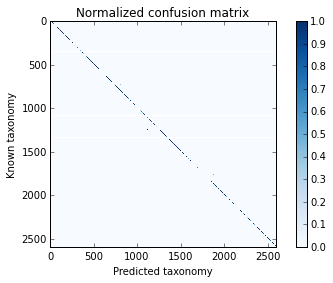

F-score: 0.828


In [19]:
from sklearn.metrics import confusion_matrix, f1_score

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

print("F-score: %1.3f" % f1_score(y_test, y_pred, average='micro'))

In [20]:
from sklearn.naive_bayes import MultinomialNB

y_pred = MultinomialNB().fit(X_train, y_train).predict(X_test)

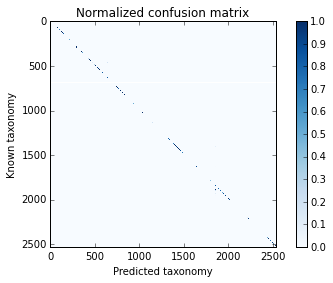

F-score: 0.641


In [21]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

print("F-score: %1.3f" % f1_score(y_test, y_pred, average='micro'))